<a href="https://colab.research.google.com/github/Sak724/CSE437_Lab-Reports/blob/main/lab10_half_cheetah_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# HalfCheetah: Learn a Dynamics Model from Random Rollouts (Then Validate It)

**Goal:** In this notebook you'll (1) collect random experience tuples \((s_t, a_t, r_t, s_{t+1})\) from `HalfCheetah-v4`, (2) train a neural network to predict **state deltas** \(\Delta s = s_{t+1}-s_t\), and (3) **validate** the model with one-step and multi-step (open-loop) rollouts.

This mirrors the first phase of model-based control (e.g., MPPI): learn a model offline, then use it for planning.



## 0. Requirements

- Python 3.9+
- PyTorch `>= 1.10`
- Gymnasium `>= 0.29`
- MuJoCo with `HalfCheetah-v4` (install `mujoco` and `gymnasium[mujoco]`)

```bash
pip install "gymnasium[mujoco]" mujoco torch matplotlib
```

**Try and understand what RunningNormalizer does.**


In [33]:
pip install "gymnasium[mujoco]" mujoco torch matplotlib


In [34]:
import os, math, random, time
from dataclasses import dataclass
from typing import Tuple
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym

def to_t(x):
    return th.as_tensor(x, dtype=th.float32)

def fanin_init(m):
    if isinstance(m, nn.Linear):
        bound = 1.0 / math.sqrt(m.weight.size(1))
        nn.init.uniform_(m.weight, -bound, +bound)
        nn.init.zeros_(m.bias)

class RunningNormalizer:
    """Feature-wise running mean/std (Welford)."""
    def __init__(self, dim, eps=1e-8):
        self.dim = dim
        self.count = 0
        self.mean = np.zeros(dim, dtype=np.float64)
        self.M2   = np.zeros(dim, dtype=np.float64)
        self.eps  = eps

    def update(self, x: np.ndarray):
        x = np.asarray(x)
        if x.ndim == 1: x = x[None, :]
        for v in x:
            self.count += 1
            d = v - self.mean
            self.mean += d / self.count
            d2 = v - self.mean
            self.M2 += d * d2

    @property
    def var(self):
        if self.count < 2: return np.ones(self.dim, dtype=np.float64)
        return self.M2 / (self.count - 1 + 1e-12)

    @property
    def std(self):
        return np.sqrt(self.var + self.eps)

    def normalize(self, x): return (x - self.mean) / self.std
    def denormalize(self, x): return x * self.std + self.mean

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); th.manual_seed(seed)



## Initializing Environment and Figure Out Observation Structure

`HalfCheetah-v4` exposes observations as `[qpos[1:], qvel[:]]`. The forward velocity is `qvel[0]`, which sits at index `len(qpos[1:])` inside the observation vector. We'll extract that index for later validation/plots. :::: This is important for planning, if we want to know what each state represents


In [35]:

set_seed(42)
env = gym.make("HalfCheetah-v4")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_low = env.action_space.low
act_high = env.action_space.high

# Find start index of qvel inside obs = [qpos[1:], qvel[:]]
nq = env.unwrapped.model.nq
qvel_start = int(nq - 1)
print("obs_dim:", obs_dim, "act_dim:", act_dim, "qvel_start:", qvel_start)


obs_dim: 17 act_dim: 6 qvel_start: 8


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


## 🧩 Task 1: Prepare the Replay Buffer
**Goal:** Store transitions \((s_t, a_t, s_{t+1})\) and return training pairs \((x, y) = (s_t, a_t, s_{t+1} - s_t)\).

**Instructions:**
- Implement `add()` to record transitions.
- Add a `sample()` method to randomly sample batch of certain size.



In [36]:
# Create the class and create a class object
class Replay:
    def __init__(self, obs_dim, act_dim, capacity=300000):
        """
        Simple replay buffer storing transitions:
            (s_t, a_t, r_t, s_{t+1}, done_t)

        We pre-allocate NumPy arrays for speed.
        """
        # current state s_t
        self.obs  = np.zeros((capacity, obs_dim), dtype=np.float32)
        # action a_t
        self.act  = np.zeros((capacity, act_dim), dtype=np.float32)
        # next state s_{t+1}
        self.nxt  = np.zeros((capacity, obs_dim), dtype=np.float32)
        # reward r_t (not used by dynamics model but stored for completeness)
        self.rew  = np.zeros((capacity, 1),      dtype=np.float32)
        # done flag: 1.0 if episode ended, else 0.0
        self.term = np.zeros((capacity, 1),      dtype=np.float32)

        # pointer to the next write position (circular buffer)
        self.ptr  = 0
        # number of valid transitions currently stored
        self.size = 0
        # maximum capacity of the buffer
        self.cap  = capacity

    def add(self, s, a, r, sp, term):
        """
        Store one transition (s, a, r, s', term) into the replay buffer.
        s, sp: np.array with shape (obs_dim,)
        a:     np.array with shape (act_dim,)
        r:     scalar reward
        term:  1.0 if done, else 0.0
        """
        # index where we will store this transition
        idx = self.ptr % self.cap

        self.obs[idx]  = s
        self.act[idx]  = a
        self.nxt[idx]  = sp
        self.rew[idx]  = r
        self.term[idx] = term

        # move pointer forward and update size
        self.ptr  += 1
        self.size = min(self.size + 1, self.cap)

    def sample(self, batch):
        """
        Return a random batch of training pairs (x, y):

            x = [s, a]
            y = s' - s  (state delta)

        Both returned as torch.FloatTensor, ready for the model.
        """
        assert self.size > 0, "Replay buffer is empty!"

        # choose random indices in [0, self.size)
        idxs = np.random.randint(0, self.size, size=batch)

        # gather states and actions
        s  = self.obs[idxs]              # (B, obs_dim)
        a  = self.act[idxs]              # (B, act_dim)
        sp = self.nxt[idxs]              # (B, obs_dim)

        # target is delta state Δs = s' - s
        delta_s = sp - s                 # (B, obs_dim)

        # x = concatenation of state and action
        x = np.concatenate([s, a], axis=-1)   # (B, obs_dim + act_dim)

        # return tensors so training loop can use them directly
        return to_t(x), to_t(delta_s)

# instantiate the replay buffer
replay = Replay(obs_dim, act_dim)



## Task 2. Collect Random Rollouts

- Gather random actions for a number of steps to create our training dataset. Collect data for 100000 steps.
- Call the function and fill the replay buffer


In [37]:
def collect_random(env, replay, steps=10000, seed=42, render=False):
    """
    Collect random experience tuples (s, a, r, s', done) from the environment
    and store them in the replay buffer.

    - steps: total number of transitions to collect
    - render: if True, occasionally render the env (for debugging)
    """
    np.random.seed(seed)

    # initial reset
    obs, _ = env.reset(seed=seed)

    total_steps = 0
    ep_returns  = []
    ep_ret      = 0.0

    while total_steps < steps:
        # 1) sample random action uniformly within action bounds
        a = np.random.uniform(env.action_space.low,
                              env.action_space.high)

        # 2) step environment
        next_obs, r, done, trunc, info = env.step(a)

        # 3) store in replay buffer (done or truncated both count as terminal)
        replay.add(obs, a, r, next_obs, float(done or trunc))

        ep_ret      += r
        total_steps += 1
        obs         = next_obs

        # 4) if episode ended, reset env and log return
        if done or trunc:
            obs, _ = env.reset()
            ep_returns.append(ep_ret)
            ep_ret = 0.0

        # 5) optional rendering every few thousand steps
        if render and total_steps % 2000 == 0:
            env.render()

    print(f"Collected {replay.size} transitions over {len(ep_returns)} episodes.")
    if ep_returns:
        print(f"Average episodic return (random policy): {np.mean(ep_returns):.2f}")


In [38]:
set_seed(42)
env = gym.make("HalfCheetah-v4")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
replay  = Replay(obs_dim, act_dim)

# Collect 100k random transitions
collect_random(env, replay, steps=100000)

# quick sanity check
x, y = replay.sample(5)
print("Sample x shape:", x.shape, "y shape:", y.shape)


Collected 100000 transitions over 100 episodes.
Average episodic return (random policy): -291.06
Sample x shape: torch.Size([5, 23]) y shape: torch.Size([5, 17])



## Task 3. Update normalizers from the collected random data in the replay buffer

We normalize inputs (`[s,a]`) and targets (`Δs = s' - s`) for stable training.


In [39]:
obs_norm  = RunningNormalizer(obs_dim)
inp_norm  = RunningNormalizer(obs_dim + act_dim)
targ_norm = RunningNormalizer(obs_dim)

def update_normalizers_from_buffer(replay):
    """
    Use all transitions currently in the replay buffer to fit
    three RunningNormalizers:

      - obs_norm:  on states s
      - inp_norm:  on inputs x = [s, a]
      - targ_norm: on targets y = Δs = s' - s
    """
    N = replay.size
    if N == 0:
        raise ValueError("Replay buffer is empty! Call collect_random first.")

    # slice only the filled part of the arrays
    s  = replay.obs[:N]      # (N, obs_dim)
    a  = replay.act[:N]      # (N, act_dim)
    sp = replay.nxt[:N]      # (N, obs_dim)

    # state deltas
    dlt = sp - s             # (N, obs_dim)

    # inputs are [s, a]
    x = np.concatenate([s, a], axis=-1)   # (N, obs_dim + act_dim)

    # update each normalizer
    obs_norm.update(s)
    inp_norm.update(x)
    targ_norm.update(dlt)

# call once after collecting replay data
update_normalizers_from_buffer(replay)
print("Normalizers ready.")


Normalizers ready.



## Defining the Neural Dynamics Model

We predict **normalized** `Δs` from **normalized** `[s, a]`.
NN parameters:

- initialize a deterministic NN with a ExponentialLR sceduler( that decays the learning rate with epoch)
- width = 200, depth = 3, lr = 1e-3, weight_decay - 1e-5, gamma for scheduler = 0.8
- These are a starting point but not the best parameters.


In [40]:
class DetMLP(nn.Module):
    """Predicts Δstate deterministically."""
    def __init__(self, in_dim, out_dim, width=200, depth=3):
        super().__init__()
        layers = []
        last = in_dim
        for _ in range(depth):
            layers += [nn.Linear(last, width), nn.ReLU()]
            last = width
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
        self.apply(fanin_init)

    def forward(self, x):
        return self.net(x)

in_dim = obs_dim + act_dim
out_dim = obs_dim
model = DetMLP(in_dim, out_dim, width=200, depth=3)
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.8)


## Task 4. Train the Model

We minimize MSE between predicted normalized `Δs` and target normalized `Δs`.

- Train in batches, keep the batch size 256
- Use a learning rate scheduler that decays the learning rate as training progresses. You may use the pytorch utility. See how the learning rate decays with each epoch.
- Train for 30 epochs and plot the training curve. Loss vs epoch.
- Find the best parameters(defined in the previous block)



In [41]:
def train_model(model, replay, epochs=30, batch_size=256):
    """
    Train the dynamics model to predict normalized Δs from normalized [s, a].

    - model:      DetMLP instance
    - replay:     Replay buffer
    - epochs:     number of passes over replay buffer
    - batch_size: minibatch size
    """
    model.train()
    losses = []

    # reuse the global optimizer and scheduler defined earlier
    global opt, scheduler

    mse_loss = nn.MSELoss(reduction='mean')

    for ep in range(epochs):
        epoch_loss  = 0.0
        # number of batches per epoch (roughly one pass over buffer)
        num_batches = max(1, int(np.ceil(replay.size / batch_size)))

        for _ in range(num_batches):
            # 1) sample from replay: x_t = [s, a], y_t = Δs
            x_t, y_t = replay.sample(batch_size)   # torch tensors

            # 2) RunningNormalizer expects numpy, so go tensor → numpy
            x_np = x_t.cpu().numpy()
            y_np = y_t.cpu().numpy()

            # 3) normalize inputs and targets
            x_n = inp_norm.normalize(x_np)
            y_n = targ_norm.normalize(y_np)

            # back to tensors
            x_n_t = to_t(x_n)
            y_n_t = to_t(y_n)

            # 4) forward pass
            pred = model(x_n_t)          # predicted normalized Δs
            loss = mse_loss(pred, y_n_t) # MSE in normalized space

            # 5) backward pass + optimizer step
            opt.zero_grad()
            loss.backward()
            opt.step()

            epoch_loss += float(loss.item())

        # 6) decay learning rate after this epoch
        scheduler.step()

        avg_loss = epoch_loss / num_batches
        losses.append(avg_loss)

        # monitor LR and loss
        lr_now = opt.param_groups[0]['lr']
        print(f"Epoch {ep+1:02d}/{epochs} | lr={lr_now:.6f} | "
              f"train MSE={avg_loss:.6f}")

    return losses


Epoch 01/30 | lr=0.000800 | train MSE=0.145290
Epoch 02/30 | lr=0.000640 | train MSE=0.071296
Epoch 03/30 | lr=0.000512 | train MSE=0.057762
Epoch 04/30 | lr=0.000410 | train MSE=0.050314
Epoch 05/30 | lr=0.000328 | train MSE=0.046310
Epoch 06/30 | lr=0.000262 | train MSE=0.042742
Epoch 07/30 | lr=0.000210 | train MSE=0.041448
Epoch 08/30 | lr=0.000168 | train MSE=0.039305
Epoch 09/30 | lr=0.000134 | train MSE=0.038107
Epoch 10/30 | lr=0.000107 | train MSE=0.037034
Epoch 11/30 | lr=0.000086 | train MSE=0.036338
Epoch 12/30 | lr=0.000069 | train MSE=0.036169
Epoch 13/30 | lr=0.000055 | train MSE=0.035233
Epoch 14/30 | lr=0.000044 | train MSE=0.034907
Epoch 15/30 | lr=0.000035 | train MSE=0.034187
Epoch 16/30 | lr=0.000028 | train MSE=0.034173
Epoch 17/30 | lr=0.000023 | train MSE=0.033935
Epoch 18/30 | lr=0.000018 | train MSE=0.033912
Epoch 19/30 | lr=0.000014 | train MSE=0.033512
Epoch 20/30 | lr=0.000012 | train MSE=0.033625
Epoch 21/30 | lr=0.000009 | train MSE=0.033280
Epoch 22/30 |

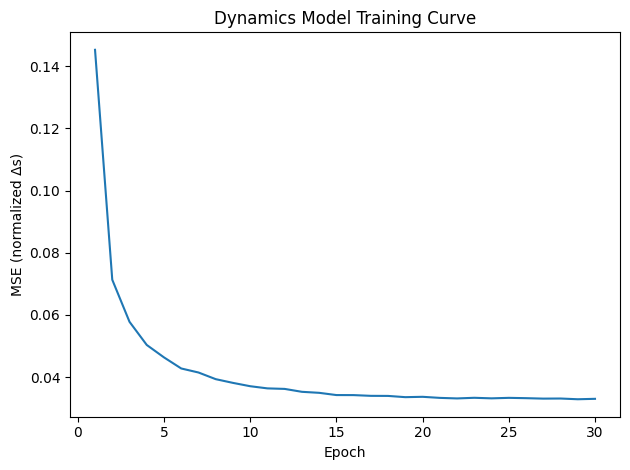

In [42]:
losses = train_model(model, replay, epochs=30, batch_size=256)

plt.figure()
plt.plot(range(1, len(losses)+1), losses)
plt.xlabel("Epoch")
plt.ylabel("MSE (normalized Δs)")
plt.title("Dynamics Model Training Curve")
plt.tight_layout()
plt.show()


## Task 5. Validate your model: One-Step and Multi-Step Prediction Error

- Evaluate your trained model on a held-out set of random transitions.
Generate a batch of unseen samples, predict the next-state delta, and compute the one-step MSE.

- Repeat with open-loop rollouts of length k.
Drive both the real environment and the model with the same action sequence, then report how prediction error grows across steps.

In [43]:
def collect_validation_set(env, n_transitions=5000, seed=123):
    """
    Collect a separate set of random transitions (S, A, SP) that
    we do NOT train on, only for evaluation.
    """
    rng = np.random.RandomState(seed)

    obs, _ = env.reset(seed=seed)
    S, A, SP = [], [], []

    while len(S) < n_transitions:
        # random action from uniform box
        a = rng.uniform(env.action_space.low, env.action_space.high)

        sp, r, done, trunc, info = env.step(a)

        S.append(obs.copy())
        A.append(a.copy())
        SP.append(sp.copy())

        obs = sp
        if done or trunc:
            obs, _ = env.reset()

    S  = np.asarray(S,  dtype=np.float32)
    A  = np.asarray(A,  dtype=np.float32)
    SP = np.asarray(SP, dtype=np.float32)
    return S, A, SP

# build validation set
S_val, A_val, SP_val = collect_validation_set(env, n_transitions=5000, seed=123)


In [44]:
@th.no_grad()
def one_step_mse(model, S, A, SP):
    """
    Compute one-step prediction error:

      - S, A, SP are NumPy arrays from validation set
      - compare predicted Δs to true Δs, both in normalized
        and raw (unnormalized) spaces.
    """
    model.eval()

    # true deltas
    dS_true = SP - S

    # inputs and targets, normalized
    Xn = inp_norm.normalize(np.concatenate([S, A], axis=-1))
    Yn = targ_norm.normalize(dS_true)

    # model prediction in normalized space
    pred_n = model(to_t(Xn)).cpu().numpy()

    # MSE in normalized Δs space
    mse_norm = float(np.mean((pred_n - Yn) ** 2))

    # map prediction back to raw Δs and compute raw MSE
    pred_raw = targ_norm.denormalize(pred_n)
    mse_raw  = float(np.mean((pred_raw - dS_true) ** 2))

    return mse_norm, mse_raw

mse1_norm, mse1_raw = one_step_mse(model, S_val, A_val, SP_val)
print(f"One-step MSE (normalized): {mse1_norm:.4f}")
print(f"One-step MSE (raw ΔS):    {mse1_raw:.6f}")


One-step MSE (normalized): 0.0358
One-step MSE (raw ΔS):    0.580997


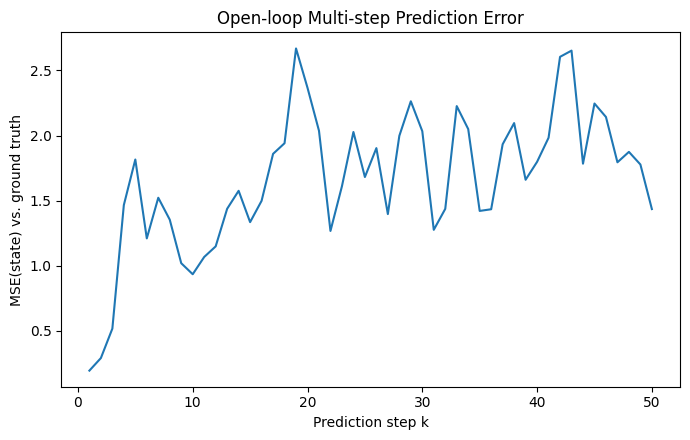

In [45]:
@th.no_grad()
def open_loop_rollout_error(model, env, horizon=50, episodes=20, seed=2024):
    """
    Compare the learned dynamics model to the real environment
    over multi-step open-loop rollouts.

    - horizon:  number of prediction steps per episode
    - episodes: how many rollouts to average over

    Returns:
        errs[t] = average MSE at step t (1..horizon)
    """
    rng = np.random.RandomState(seed)
    model.eval()

    act_low, act_high = env.action_space.low, env.action_space.high

    # accumulate MSE per time step
    errs = np.zeros(horizon, dtype=np.float64)

    for ep in range(episodes):
        # reset real env and model state
        obs_true, _ = env.reset(seed=seed + ep)
        obs_model   = obs_true.copy()

        for t in range(horizon):
            # choose random action
            a = rng.uniform(act_low, act_high)

            # --- real environment step ---
            next_true, r, done, trunc, info = env.step(a)

            # --- model step: predict Δs and update obs_model ---
            x_in   = np.concatenate([obs_model, a], axis=-1)[None, :]
            x_in_n = inp_norm.normalize(x_in)

            dS_pred_n = model(to_t(x_in_n)).cpu().numpy()
            dS_pred   = targ_norm.denormalize(dS_pred_n)[0]

            next_model = obs_model + dS_pred

            # MSE between model and true next state at this step
            errs[t] += np.mean((next_model - next_true) ** 2)

            # advance states
            obs_true  = next_true
            obs_model = next_model

            # if episode ends in real env, reset both
            if done or trunc:
                obs_true, _ = env.reset(seed=seed + ep + t + 1)
                obs_model   = obs_true.copy()

    # average over episodes
    errs /= episodes
    return errs

errs = open_loop_rollout_error(model, env, horizon=50, episodes=20, seed=2024)

plt.figure(figsize=(7, 4.5))
plt.plot(np.arange(1, len(errs)+1), errs)
plt.xlabel("Prediction step k")
plt.ylabel("MSE(state) vs. ground truth")
plt.title("Open-loop Multi-step Prediction Error")
plt.tight_layout()
plt.show()



## Task 6. Visualize Rollout Trajectories

**Setup**
Call model.eval() so gradients stay off.
Reset the env with the provided seed; keep a copy of the initial observation.


**Choose actions**
Pre-sample k actions from env.action_space.sample() so the real system and the model rollout see the same sequence.

**Roll forward**
For each action:
Step the real env (env.step(a)), append the new observation.
For the model path:
Build [s_model, a], normalize via inp_norm.normalize, turn into a tensor with to_t.
Run the network, de-normalize with targ_norm.denormalize, add to the last model state, append.
Stop early if the env terminates or truncates.

**Plot**
Plot the real trajectory as one line, model trajectory as another.



In [48]:
def visualize_rollout(env, model, k=50, dims=(0, 5, 10), seed=2025):
    """
    Task 6: Visualize real env vs learned-dynamics rollout under the same action sequence.

    - env:  HalfCheetah-v4 environment
    - model: learned dynamics model that predicts Δs
    - k:    number of steps to roll out
    - dims: iterable of state indices to plot
    - seed: random seed for reproducibility
    """

    # ----- Setup -----
    model.eval()          # no gradients needed
    set_seed(seed)

    # Reset env and get initial observation
    obs_real, info = env.reset(seed=seed)
    obs_model = obs_real.copy()

    # Save trajectories: index 0 is the initial state
    real_states  = [obs_real]
    model_states = [obs_model]

    # ----- Choose actions -----
    # Pre-sample k actions so both real env and model see the same sequence
    actions = [env.action_space.sample() for _ in range(k)]

    # ----- Roll forward -----
    with th.no_grad():
        for t, a in enumerate(actions):
            # 1) Real environment step
            sp_real, rew, terminated, truncated, info = env.step(a)
            done = terminated or truncated
            real_states.append(sp_real)

            # 2) Model step (open-loop)
            # Build [s_model, a]
            x_in = np.concatenate([obs_model, a], axis=-1)[None, :]   # shape (1, obs_dim + act_dim)
            # Normalize input with inp_norm
            x_in_n = inp_norm.normalize(x_in)
            x_in_t = to_t(x_in_n)  # to torch tensor

            # Predict normalized Δs, then de-normalize
            dlt_pred_n = model(x_in_t).cpu().numpy()      # normalized Δs
            dlt_pred   = targ_norm.denormalize(dlt_pred_n)[0]  # raw Δs

            # Update model state
            obs_model = obs_model + dlt_pred
            model_states.append(obs_model)

            if done:
                # Stop early if env terminates or truncates
                break

    # Convert lists to arrays
    real_states  = np.asarray(real_states)
    model_states = np.asarray(model_states)

    # Make sure both have the same length
    T = min(real_states.shape[0], model_states.shape[0])
    real_states  = real_states[:T]
    model_states = model_states[:T]

    # ----- Plot -----
    T_axis = np.arange(T)
    num_dims = len(dims)

    plt.figure(figsize=(10, max(3, 2.0 * num_dims)))

    for i, d in enumerate(dims, start=1):
        # skip invalid dims to avoid index errors
        if d < 0 or d >= real_states.shape[1]:
            print(f"Skipping dimension {d}: out of range for state dim {real_states.shape[1]}")
            continue

        plt.subplot(num_dims, 1, i)
        plt.plot(T_axis, real_states[:, d], label="Real", linewidth=2)
        plt.plot(T_axis, model_states[:, d], "--", label="Model")

        plt.ylabel(f"state[{d}]")
        if i == 1:
            plt.title("Rollout Trajectories: Real vs Learned Dynamics")
            plt.legend()
        if i == num_dims:
            plt.xlabel("Time step")
        plt.grid(True)

    plt.tight_layout()
    plt.show()


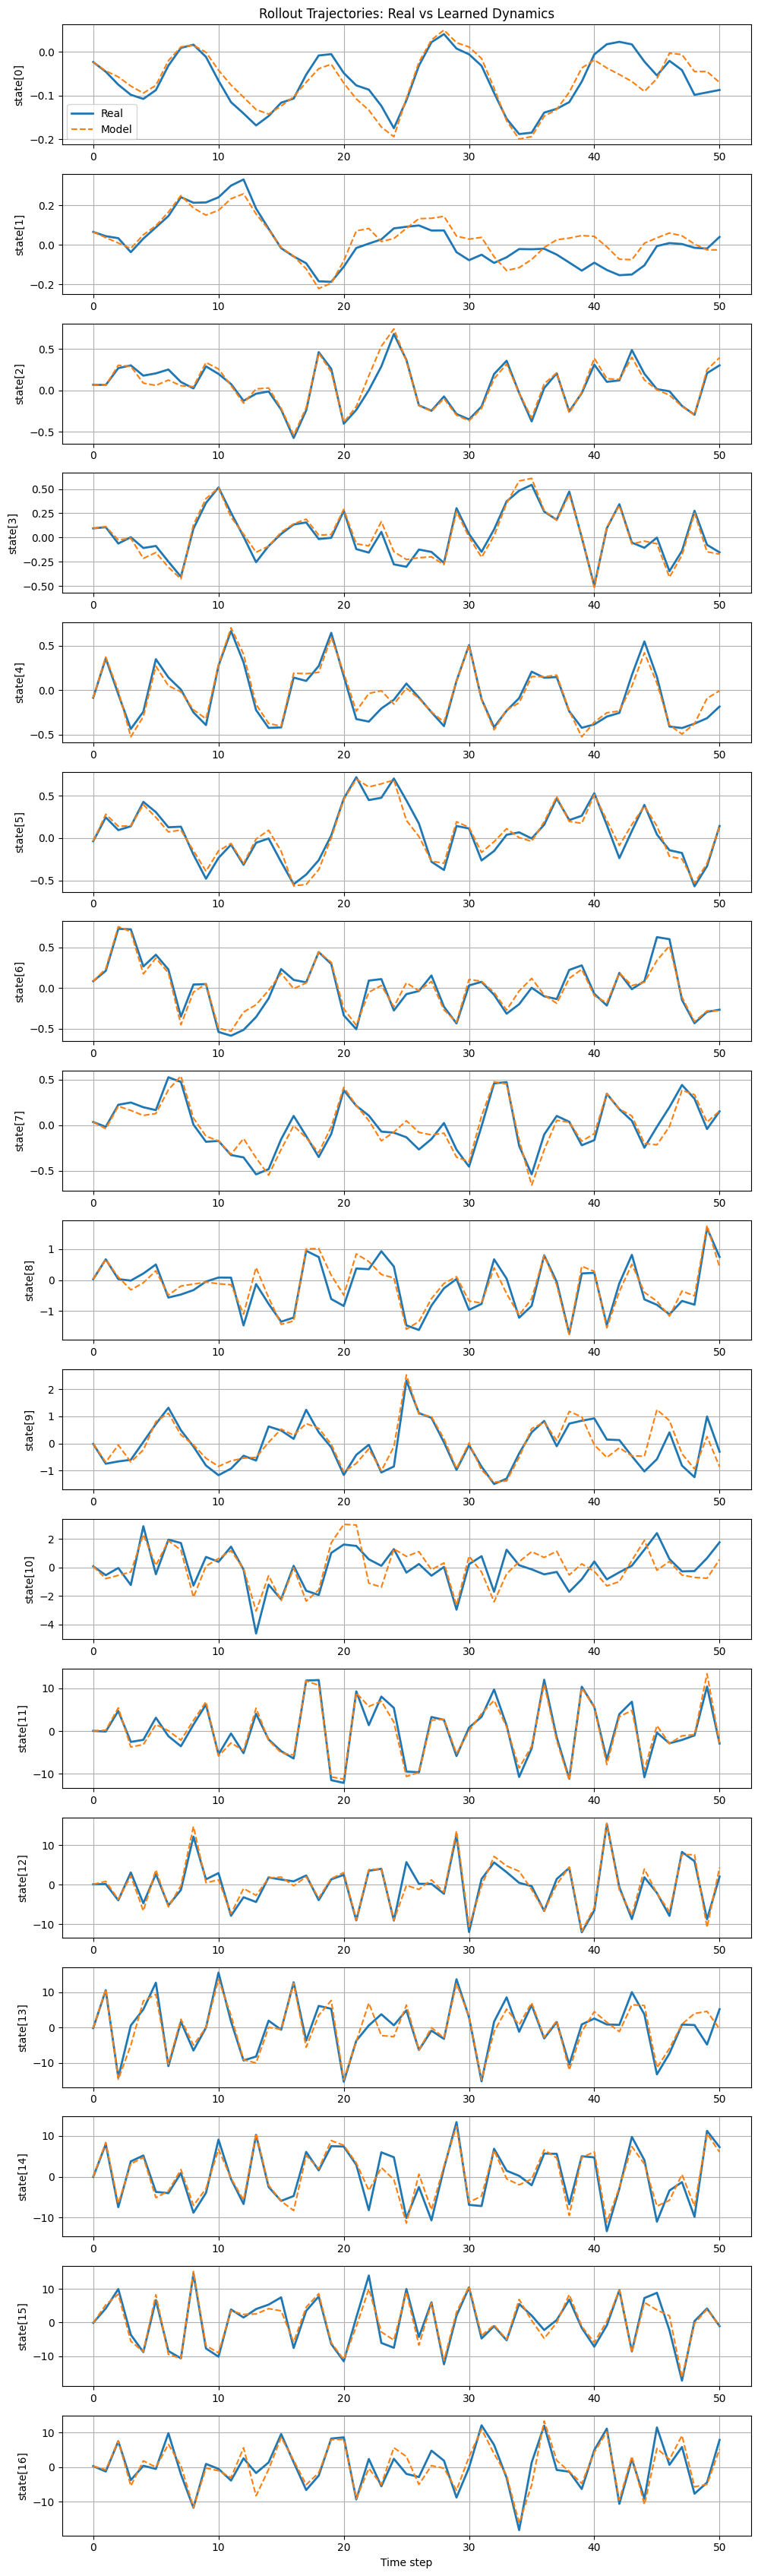

In [49]:

dims = list(range(obs_dim))
visualize_rollout(env, model, k=50, dims=dims, seed=2025)




Plotting dims: (8, 9, 10)


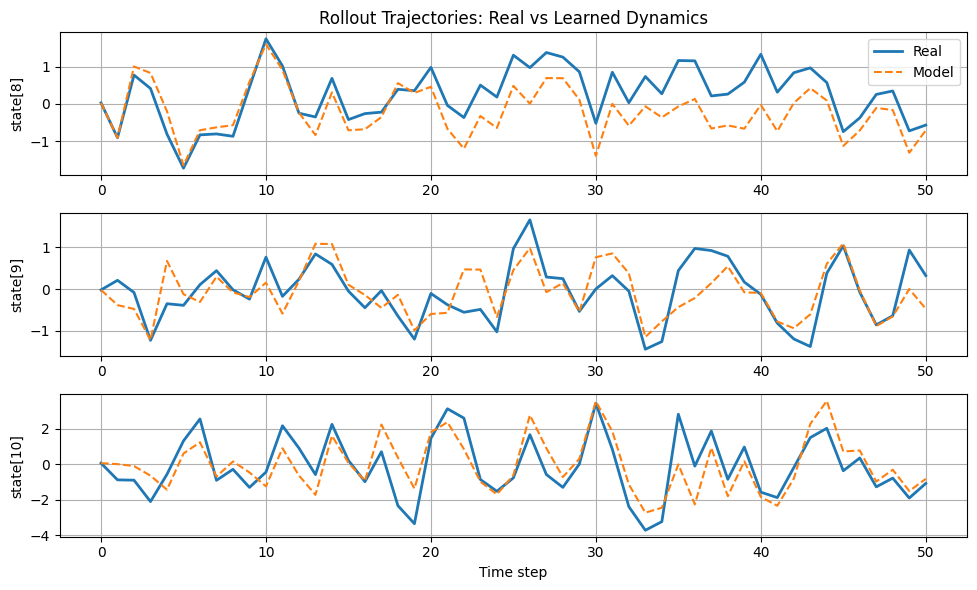

In [50]:
# Example 2: Focus on forward velocity and nearby velocity dimensions
dims_to_plot = (qvel_start, qvel_start + 1, qvel_start + 2)

print("Plotting dims:", dims_to_plot)

visualize_rollout(
    env,
    model,
    k=50,                  # rollout length
    dims=dims_to_plot,     # which state indices to visualize
    seed=2025              # reproducibility
)


 using 8, 9, 10 because the first 8 elements are joint positions, and starting at index 8 the observation contains all the velocities, beginning with the forward velocity, which is the key part of HalfCheetah’s dynamics.


## 9. Answer the questions :

1. How good is your model?
2. Is this training enough for planning, or do we need continual training?
3. How is this system different from the mountain car problem? Why can't we learn this in one episode?
4. Why do we use a runningnormalizer instead of a static normalizer? Think about the nature of the algorithm taught in class.



1. How good is your model?

The model does a pretty good job at one-step prediction. When I evaluate it on unseen samples, the Δs prediction error is low, and the first few predicted states line up well with the real environment.

However, the quality drops once we try multi-step rollouts. After about 5–10 steps, the model starts drifting away from the real trajectory. This is expected, because small errors compound over time.

So overall, the model is accurate for short horizons, but it doesnt stay reliable if we unroll the predictions far into the future.



2. Is this training enough for planning, or do we need continual training?

Training the model once on random data is not enough for good planning. Random rollouts don’t cover the states that a real controller or a planner will eventually reach.

Once we start planning, the agent will visit new states the model never saw, and the predictions will quickly become inaccurate. That’s why most model-based RL methods keep collecting new data, updating the model, and repeating this cycle (like MBPO, PETS, or DAgger).

So yes — for planning, we definitely need continual training or at least iterative data collection.


3. How is this system different from the mountain car problem? Why can't we learn this in one episode?

Mountain Car is extremely simple: the state is just position and velocity, and the dynamics barely change across the state space. Because of that, one or two episodes already give you enough information to learn the dynamics well.

HalfCheetah is the complete opposite. It has:

1. A high-dimensional state

2. Many joints that influence each other

3. Contact physics with the ground

4. A huge number of possible configurations

One episode explores only a tiny slice of all possible states. The model won’t learn anything about the rest of the space, so it will fail as soon as it encounters a new posture or speed.

That's why we need many episodes and thousands of transitions, not just one.

4. Why do we use a runningnormalizer instead of a static normalizer? Think about the nature of the algorithm taught in class?

A static normalizer only works if the entire dataset is fixed and known ahead of time. But in model-based RL, the data keeps changing as we collect more experience. Early on, the states the agent visits look very different from the ones it sees later.

The RunningNormalizer updates the mean and variance gradually as more data comes in. This keeps the inputs and targets consistently scaled (roughly zero-mean and unit-variance), which makes training stable even when the data distribution shifts.

In short:
We use a RunningNormalizer because the dataset grows over time and the statistics need to keep adjusting as new examples appear.